In [188]:
#importy
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt


In [189]:
#stale
L = 2

In [190]:
#dziedzina
geometry1 = dde.geometry.Hypercube(xmin=[-L/2, -L/2, 0.99, 0.99], xmax=[L/2, L/2, 1.01, 1.01])
geometry2 = dde.geometry.Hypercube(xmin=[-L/2, -L/2, 1.99, 1.99], xmax=[L/2, L/2, 2.01, 2.01])

geometry = dde.geometry.CSGUnion(geometry1, geometry2)
geometry = geometry1




In [191]:
#funkcja
def pde(x, u):
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    n1 = x[:, 2:3]
    n2 = x[:, 3:4]
    return (du_xx + du_yy)/2 + (n1**2 + n2**2) * np.pi**2 * u / (2 * L**2)

def solution(x):
    xi = x[:, 0:1]
    yi = x[:, 1:2]
    n1 = x[:, 2:3]
    n2 = x[:, 3:4]
    
    return 2/L * np.sin(n1*np.pi*(xi+L/2) / L) * np.sin(n2*np.pi*(yi+L/2) / L)



In [192]:
#warunki brzegowe

def boundaryFunction(x, on_boundary):
    if on_boundary and (dde.utils.isclose(abs(x[0]), L/2) or dde.utils.isclose(abs(x[1]), L/2)):
        return True
    return False


boundary_conditions = dde.icbc.DirichletBC(geometry, 
                                            lambda x: 0, 
                                            boundaryFunction
                                            )


In [193]:
#dane
data = dde.data.PDE(geometry, 
                    pde, 
                    boundary_conditions, 
                    num_domain=1200,
                    num_boundary=120,
                    num_test=1500
                    )

In [194]:
#siec
net = dde.nn.FNN([4]+[20]*3+[1],
                "tanh",
                "Glorot normal"
                )

In [195]:
#model
model = dde.Model(data, net)

model.compile("adam", lr=0.001)

Compiling model...
Building feed-forward neural network...
'build' took 0.075613 s

'compile' took 1.227815 s



Training model...

Step      Train loss              Test loss               Test metric
0         [2.97e-01, 6.79e-02]    [2.91e-01, 6.79e-02]    []  
500       [1.34e-04, 4.14e-05]    [8.88e-05, 4.14e-05]    []  
1000      [5.23e-05, 1.64e-05]    [1.79e-05, 1.64e-05]    []  
1500      [3.61e-05, 8.19e-06]    [8.05e-06, 8.19e-06]    []  
2000      [2.53e-05, 4.31e-06]    [4.19e-06, 4.31e-06]    []  
2500      [1.71e-05, 2.42e-06]    [2.45e-06, 2.42e-06]    []  
3000      [1.08e-05, 1.40e-06]    [1.60e-06, 1.40e-06]    []  
3500      [6.24e-06, 7.76e-07]    [1.07e-06, 7.76e-07]    []  
4000      [3.58e-05, 5.78e-06]    [3.33e-05, 5.78e-06]    []  
4500      [5.09e-06, 8.37e-07]    [3.80e-06, 8.37e-07]    []  
5000      [9.74e-07, 1.37e-07]    [2.63e-07, 1.37e-07]    []  

Best model at step 5000:
  train loss: 1.11e-06
  test loss: 4.00e-07
  test metric: []

'train' took 28.601682 s

Saving loss history to /home/filipjedrzejewski/MetodyObliczeniowe/lab10/loss.dat ...
Saving training d

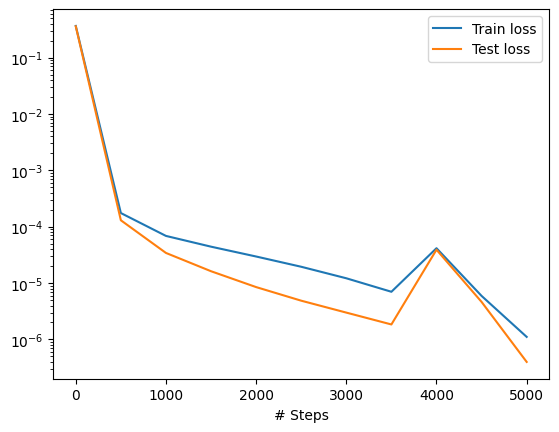

In [196]:
#trenowanie
loss_history, train_state = model.train(iterations = 5000, display_every=500)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)


In [197]:
#testowanie
xData = np.linspace(-L/2, L/2, 1000)
yData = np.linspace(-L/2, L/2, 1000)
n1 = np.array([1 for i in range(1000)])
n2 = np.array([1 for i in range(1000)])

X = np.vstack((np.ravel(xData), np.ravel(yData), np.ravel(n1), np.ravel(n2))).T

y_pred = model.predict(X)

y_true = solution(X)

singleData = np.vstack(([0], [0], [1], [1])).T
print(model.predict(singleData))
print(solution(singleData))




[[0.00067643]]
[[1.]]


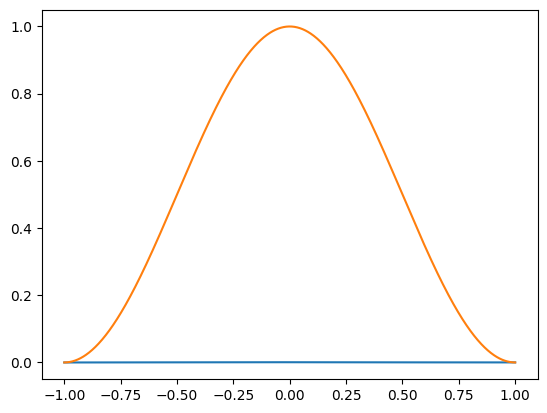

In [198]:
#wykresy
plt.plot(X[:, 0:1], y_pred)
plt.plot(X[:, 0:1], y_true)
plt.show()

